### Libraries

In [263]:
#Data Manipulation
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

#Utilities
import time
import warnings
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils import shuffle
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

#Models
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_2022_2023_2024.csv",
        "trainingSize": .60,
        "validationSize": .2,
        "testSize": .2
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    }
}

In [264]:
def plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=X_train_dates, y=y_train, mode="lines", name="Train"))
    fig.add_trace(go.Scatter(x=X_val_dates, y=y_val, mode="lines", name="Validation"))
    fig.add_trace(go.Scatter(x=X_test_dates, y=y_test, mode="lines", name="Test"))
    fig.update_layout(
        title = "Dataset Partition",
        xaxis_title = "Date",
        yaxis_title ="Demand (kWh)",
        width = 1000,
        height = 400,
        margin = dict(l=30, r=20, t=35, b=60),
        legend = dict(
            orientation = "h",
            yanchor = "bottom",
            y = 1.05,
            xanchor = "right",
            x=1
        )
    )
    fig.show()

In [265]:
def plotPredictions(dates, y_pred, y_test):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    fig.show()

In [266]:
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test, y_pred)

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test, y_pred_permuted)

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

In [267]:
def addNLags(df, lags=1):
    lag_df= df.copy()
    for i in range(2, lags + 1):
        lag_df[f'lag_{i}'] = lag_df["Demand"].shift(i * 96)

    return lag_df.dropna()

In [268]:
def normalizeData(data):
    df = data.copy()
    df = df.drop("Demand", axis=1)
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

## Machine Learning Models

### Split Dataset

In [269]:
df = pd.read_csv(parameters["dataset"]["path"], index_col=None)
df["Date"] = pd.to_datetime(df["Date"])
dates = df["Date"]
dates = pd.to_datetime(dates)
df = df.drop(columns=["Date", "Minute",  "Consumo_red [kW]"], axis=1)
df = df.rename(columns={'Consumo_total [kW]': 'Demand', 'Consumo_total [kW]_-24h': 'Demand_24h', 'Consumo_total [kW]_-7d': 'Demand_7d'})
df = addNLags(df, 10)

y = df["Demand"]
X = df.drop(columns=["Demand"], axis=1)
col_names = list(X.columns)

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X.loc[:trainingSize, :].copy(), y.loc[:trainingSize].copy()
X_val, y_val = X.loc[trainingSize:validationSize, :].copy(), y.loc[trainingSize:validationSize].copy()
X_test, y_test = X.loc[validationSize:, :].copy(), y.loc[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
df.columns

Total Lags: 81309
Training Size:47826
Validation Size:16262
Test Size: 17223


Index(['Unnamed: 0', 'pres [mb]', 'slp [mb]', 'wind_dir [m/s]',
       'wind_gust_spd [m/s]', 'wind_spd [m/s]', 'temp [C]', 'app_temp [C]',
       'rh [%]', 'dewpt [C]', 'clouds [%]', 'vis [Km]', 'precip [mm]',
       'dhi [W/m^2]', 'dni [W/m^2]', 'ghi [W/m^2]', 'solar_rad [W/m^2]',
       'uv [0-11+]', 'elev_angle [º]', 'azimuth [º]', 'Temp interna Modulo',
       'Temp interna Modulo [C]', 'PV Wh', 'Year', 'Month', 'Hour',
       'DayOfWeek', 'DayOfYear', 'Demand', 'Demand_7d', 'isWeekend',
       'Hour_sen', 'Hour_cos', 'Hour_sin', 'DayOfWeek_sin', 'DayOfWeek_cos',
       'Month_sin', 'Month_cos', 'DayOfYear_sin', 'DayOfYear_cos',
       'Demand_24h', 'isHoliday', 'Season', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10'],
      dtype='object')

In [270]:
plotDatasetSplit(X_train_dates, X_val_dates, X_test_dates, y_train, y_val, y_test)

### Models to Test

In [271]:
models, models_names = [], []

#Tree Models

for n in [500, 800]:
    LGBM = LGBMRegressor(boosting_type='gbdt', n_estimators=n, learning_rate=0.01, random_state=123, n_jobs=-1, verbose=0)
    XGB = XGBRegressor(n_estimators=n, random_state=123, learning_rate=0.005, max_depth=5)
    GBM = GradientBoostingRegressor(n_estimators=n, random_state=123)
    models.append(LGBM)
    models_names.append("LGBM_" + str(n))
    models.append(XGB)
    models_names.append("XGB_" + str(n))
    models.append(GBM)
    models_names.append("GBM_" + str(n))


#KNNr
for n in [10, 20]:
    KNNR = KNeighborsRegressor(n_neighbors=n, weights = 'uniform')
    models.append(KNNR)
    models_names.append("KNNr_" + str(n) + "_" + 'uniform')
        
#Other Models


### Walking Forward Validation

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*lmUY2pKwxu5kwA1II6yAbQ.png" width=600px></img>
</div>


In [272]:
def walkForwardValidation(X, y, X_test, y_test, models, models_names, params, plot=False, fixed_train=False):
    n_splits = params['validation']['n_splits']
    results = pd.DataFrame(columns=["Model", "RMSE_Test", "RMSE_Val", "MAE_Test", "MAE_Val","Mean_MRSE_Test", "Mean_MAE_Test", "Mean_RMSE_Val", "Mean_MAE_Val"])
    for model, model_name in tqdm(zip(models, models_names), total=len(models)):
        X_test2 = X_test.copy()
        X2 = X.copy()

        if 'KNN' in model_name or 'SVR' in model_name:
            X_test2 = normalizeData(X_test2)
            X2 = normalizeData(X2)
            
        if fixed_train:
            tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=X.shape[0] // n_splits)
        else:
            tscv = TimeSeriesSplit(n_splits=n_splits)
        rmse_test, rmse_val, mae_test, mae_val = [], [], [], []
        for i, (train_index, eval_index) in enumerate(tscv.split(X2)):
            X_train, X_val = X2[train_index], X2[eval_index]
            y_train, y_val = y[train_index], y[eval_index]
            model.fit(X=X_train, y=y_train)

            #Validation Scores
            y_pred_val = model.predict(X_val)
            mae_val.append(mean_absolute_error(y_val, y_pred_val))
            rmse_val.append(root_mean_squared_error(y_val, y_pred_val))
            
            #Test Scores
            y_pred_test = model.predict(X_test2)
            mae_test.append(mean_absolute_error(y_test, y_pred_test))
            rmse_test.append(root_mean_squared_error(y_test, y_pred_test))
            
        print(f"Model: {model_name} ===> Mean Test MAE: {np.mean(mae_test)}, RMSE: {np.mean(rmse_test)}")
        results.loc[len(results.index)] = [model_name, rmse_test, rmse_val, mae_test, mae_val, np.mean(rmse_test), np.mean(mae_test), np.mean(rmse_val), np.mean(mae_val)] 
    
    #Plots
    if plot:
        titles = ["RMSE Evolution in Validation", "MAE Evolution in Validation", "RMSE Evolution in Test", "MAE Evolution in Test"]
        metric_names = ["RMSE_Val", "MAE_Val", "RMSE_Test", "MAE_Test"]
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
        for i in range(4):
            metric_name = metric_names[i]
            title = titles[i]
            row = i // 2
            col = i % 2
            ax = axes[row, col]
            for index, row in results.iterrows():
                model_name = row["Model"]
                metric_values = row[metric_name]
                ax.plot(metric_values, label=model_name)

            ax.set_title(title)
            ax.set_xlabel("Fold")
            ax.set_ylabel(metric_name)
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()
    return results

In [273]:
results = walkForwardValidation(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=False)
#results.to_csv("../data/Processed_Data/Walking_Forward_Validation_NoFix.csv", index=None)

 12%|█▎        | 1/8 [00:35<04:06, 35.24s/it]

Model: LGBM_500 ===> Mean Test MAE: 2.1622880115394754, RMSE: 3.477706194733895


 25%|██▌       | 2/8 [01:05<03:12, 32.05s/it]

Model: XGB_500 ===> Mean Test MAE: 2.1849563786090505, RMSE: 3.4376477334295688


 25%|██▌       | 2/8 [03:14<09:43, 97.18s/it]


KeyboardInterrupt: 

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*M3WnQy2H4GFtTctSgvQ48g.png" width=600px>
</div>


In [ ]:
results = walkForwardValidation(pd.concat([X_train, X_val], axis=0).to_numpy(), pd.concat([y_train, y_val], axis=0).to_numpy(), X_test, y_test, models, models_names, parameters, plot=True, fixed_train=True)
results.to_csv("../data/Processed_Data/Walking_Forward_Validation_Fix.csv", index=None)

  0%|          | 0/8 [00:03<?, ?it/s]


KeyboardInterrupt: 

### Grid Search (XGBOOST)

In [ ]:
params = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.01],
    'gamma': [3, 5],
    'colsample_bytree' : [0.5, 0.6, 0.7, 0.8],
    'colsample_bynode': [0.5, 0.7, 0.9, 1],
    'n_estimators': [1100]
}

def gridSearch(params):
    best_mae = float('inf')
    config = {}
    for param in tqdm(ParameterGrid(params), total=len(list(ParameterGrid(params)))):
        max_depth = param.get('max_depth')
        n_estimators = param.get('n_estimators')
        lr = param.get('learning_rate')
        gamma = param.get('gamma')
        colsample_bytree = param.get('colsample_bytree')
        colsample_bynode = param.get('colsample_bynode')
        regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=n_estimators, learning_rate = lr, max_depth=max_depth, colsample_bytree = colsample_bytree, colsample_bynode = colsample_bynode, gamma=gamma, random_state=123, eval_metric='mae', early_stopping_rounds=100)
        regressorXGBR.fit(
            X = X_train,
            y = y_train,
            eval_set=[(X_val, y_val)],
            verbose=0
        )  
        y_pred = regressorXGBR.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        if mae < best_mae: 
            best_mae = mae
            config = param
        print(f"MAE: {mae}, n_Estimators: {n_estimators}, Learning_rate: {lr}, Max_depth: {max_depth}, Gamma: {gamma}, Col_Sample_By_Tree: {colsample_bytree}, Col_Sample_By_Node: {colsample_bynode}")
    return config

gridSearch(params)

  0%|          | 0/128 [00:00<?, ?it/s]


ValueError: feature_names must be string, and may not contain [, ] or <

### Feature Importance 

In [238]:
regressorXGBR = XGBRegressor(objective='reg:absoluteerror', n_estimators=1100, learning_rate = 0.05, max_depth=5, colsample_bytree = 0.5, colsample_bynode = 0.5, gamma=5, random_state=123, eval_metric='mae', early_stopping_rounds=100)
regressorXGBR.fit(
    X = X_train,
    y = y_train,
    eval_set=[(X_val, y_val)],
    verbose=0
)

y_pred = regressorXGBR.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")

imp_df = pd.DataFrame(data=regressorXGBR.feature_importances_, index=regressorXGBR.feature_names_in_, columns=['importance'])
imp_df.sort_values(by=["importance"])

MAE: 1.8057779878153226, RMSE: 3.257518500809056


importance
precip                   0.003121
vis                      0.003481
wind_dir                 0.003716
rh                       0.003892
wind_spd                 0.004024
wind_gust_spd            0.004571
azimuth                  0.004824
pres                     0.005283
dewpt                    0.005760
slp                      0.005975
app_temp                 0.005999
temp                     0.006207
Temp interna Modulo      0.006656
Hour_sin                 0.007400
Temp interna Modulo.1    0.008113
Hour_sen                 0.008498
lag_8                    0.008555
Month_cos                0.008556
DayOfYear_cos            0.008557
ghi                      0.008749
lag_9                    0.008946
clouds                   0.009021
DayOfYear                0.009220
lag_4                    0.009369
DayOfWeek_cos            0.009586
Month_sin                0.009618
DayOfYear_sin            0.009694
Hour                     0.009708
lag_10                   0.009781
uv                       0.010228
lag_5                    0.010322
Month                    0.010965
dni                      0.011119
DayOfWeek_sin            0.012442
Season                   0.012611
Year                     0.014960
PV Wh                    0.014966
isWeekend                0.015077
lag_3                    0.015658
DayOfWeek                0.018475
solar_rad                0.022122
isHoliday                0.028882
dhi                      0.033940
lag_6                    0.035538
lag_2                    0.035718
elev_angle               0.048399
Demand_24h               0.053587
lag_7                    0.095987
Demand_7d                0.119145
Hour_cos                 0.172979

100%|██████████| 50/50 [00:03<00:00, 16.06it/s]


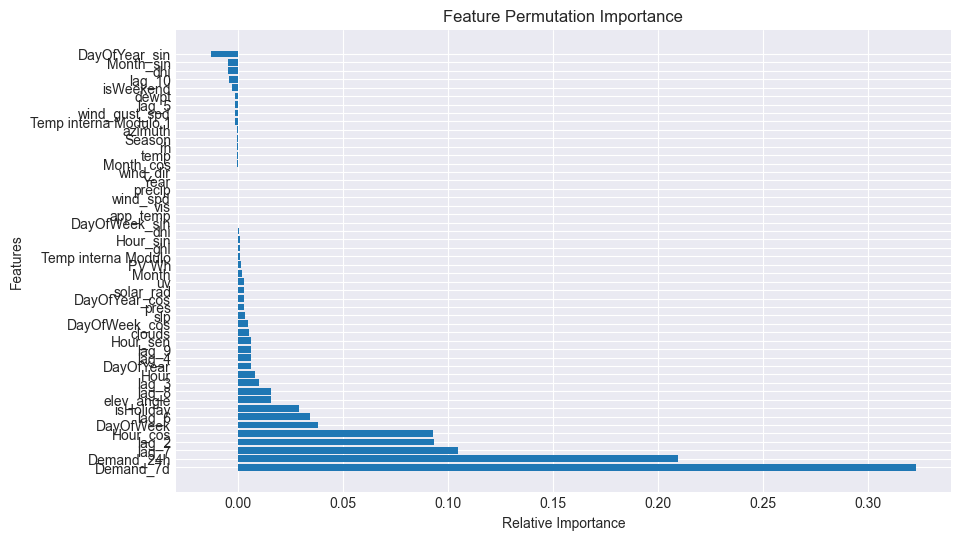

In [233]:
permutation_feature_importance(regressorXGBR, X_test.to_numpy(), y_test.to_numpy(), np.array(col_names))

### Plot Prediction Results

In [234]:
plotPredictions(X_test_dates, y_pred, y_test)

In [236]:
plotPredictions(X_test_dates[:96*24], y_pred[:96*24], y_test[:96*24])

In [237]:
plotPredictions(X_test_dates[:96*7], y_pred[:96*7], y_test[:96*7])

In [240]:
print(f"Test Demand Min: {np.min(y_test)} - Max: {np.max(y_test)}")
print(f"Predicted Demand Min: {np.min(y_pred)} - Max: {np.max(y_pred)}")

Test Demand Min: 0.0 - Max: 34.284
Predicted Demand Min: 1.8404172658920288 - Max: 17.002098083496094
